In [1]:
# imports
import os  # interacting with the system to navigate through files.
from PIL import Image # Used for opening and saving images
import numpy as np
import torch
from torchvision import transforms # Used for transforming images
from torch.utils.data import Dataset # loading and managing datasets
import cv2  # OpenCV for image processing
from tqdm import tqdm  # Import tqdm for the progress bar
import matplotlib.pyplot as plt  # For visualization

In [2]:
image_folder = 'AID'  # Directory containing the AID dataset images
original_images_dir = 'original_images'
noisy_images_dir = 'noisy_images'

# Create directories for saving images
os.makedirs(original_images_dir, exist_ok=True)
os.makedirs(noisy_images_dir, exist_ok=True)

In [3]:
# Define a transformation pipeline for lower resolution images
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [4]:
# Function to save images
def save_image(tensor, path):
    image = tensor.numpy().transpose(1, 2, 0)  # Convert CHW to HWC format
    image = (image * 255).astype(np.uint8)  # Convert from float tensor in range [0,1] to uint8 in range [0,255]
    Image.fromarray(image).save(path)

In [5]:
def add_smearing_noise(img, smear_length=30):
    height, width, channels = img.shape
    output = np.copy(img).astype(np.float32)  # Start with a copy of the original image

    # Calculate weights decreasing exponentially for the smear effect
    weights = np.power(0.7, np.arange(smear_length))[None, None, :]  # Reshape for broadcasting

    # Apply the weights to smear the pixels to the right
    for offset in range(1, smear_length):
        if offset < width:  # Ensure we don't go out of image bounds
            # Apply exponential decay to the pixel's contribution as it moves to the right
            output[:, :-offset] += weights[..., offset] * img[:, offset:].astype(np.float32)
        else:
            break

    # Normalize the result to prevent overflow and clipping
    norm_factor = np.sum(weights[..., :smear_length], axis=-1) + 1  # Include the original pixel in the normalization
    output = np.clip(output / norm_factor, 0, 255)  # Clip values to maintain the 0-255 range

    return output.astype(np.uint8)  # Convert back to unsigned byte format

In [6]:
# Get a list of all image files
all_image_files = []
for root, _, files in os.walk(image_folder):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            all_image_files.append(os.path.join(root, file))

In [7]:
# Process images
for idx, img_path in enumerate(tqdm(all_image_files, desc="Processing images")):
    # Open the image
        with Image.open(img_path).convert('RGB') as img:
            # Apply the transform to resize the image
            img_resized = transform(img)
            # Save the resized original image
            original_save_path = os.path.join(original_images_dir, f"original_{idx}.png")
            save_image(img_resized, original_save_path)
            
            # Convert the resized image to numpy for noise addition
            img_resized_np = img_resized.permute(1, 2, 0).numpy()  # Convert tensor to HWC format
            img_resized_np = (img_resized_np * 255).astype(np.uint8)  # Convert to uint8

            # Adding smearing noise
            noisy_image_np = add_smearing_noise(img_resized_np.copy())
            
            # Convert the noisy image back to tensor
            noisy_image_tensor = torch.tensor(noisy_image_np).permute(2, 0, 1).float() / 255  # Convert HWC to CHW format and scale to [0, 1]

            # Save the noisy image
            noisy_save_path = os.path.join(noisy_images_dir, f"noisy_{idx}.png")
            save_image(noisy_image_tensor, noisy_save_path)

Processing images: 100%|█████████████████████████████████████████████████████████| 10000/10000 [02:35<00:00, 64.29it/s]


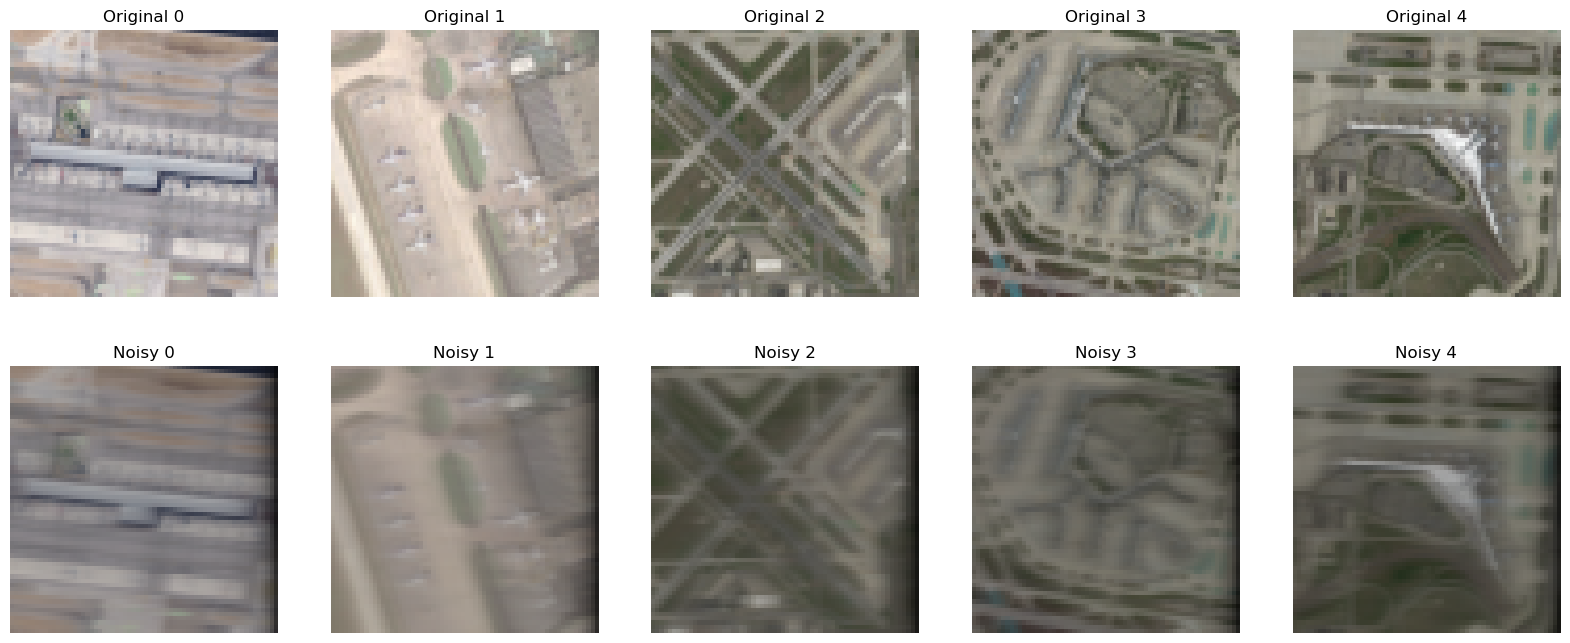

In [8]:
def visualize_images(original_images_dir, noisy_images_dir, num_images=5):
    plt.figure(figsize=(20, 8))
    for idx in range(num_images):
        original_image_path = os.path.join(original_images_dir, f"original_{idx}.png")
        noisy_image_path = os.path.join(noisy_images_dir, f"noisy_{idx}.png")

        original_image = Image.open(original_image_path)
        noisy_image = Image.open(noisy_image_path)

        # Original image
        ax = plt.subplot(2, num_images, idx + 1)
        plt.imshow(original_image)
        plt.axis('off')
        ax.set_title(f"Original {idx}")

        # Noisy image
        ax = plt.subplot(2, num_images, num_images + idx + 1)
        plt.imshow(noisy_image)
        plt.axis('off')
        ax.set_title(f"Noisy {idx}")

    plt.show()

# Visualizing the images
visualize_images(original_images_dir, noisy_images_dir, num_images=5)